# Get the Class names 

This file contains a subset of the quick draw classes. I choose around 100 classes from the dataset. 

In [1]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'

'wget' is not recognized as an internal or external command,
operable program or batch file.


Read the classes names 

In [1]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [2]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the Dataset 

Loop over the classes and download the currospondent data

In [3]:
!mkdir data

In [4]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [5]:
download() 

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/circle.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/square.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/star.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/moon.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eye.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy


# Imports 

In [1]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

# Load the Data 

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 5000 images per class.  

In [2]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 8000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    print(x.shape[0])

    #separate into training and testing 
    vfold_size = int(x.shape[0]/8*(vfold_ratio*8))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [3]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

64000


In [4]:
print(len(x_train))
print(x_train.shape)

51200
(51200, 784)


Show some random data 

3979
(784,)
sun


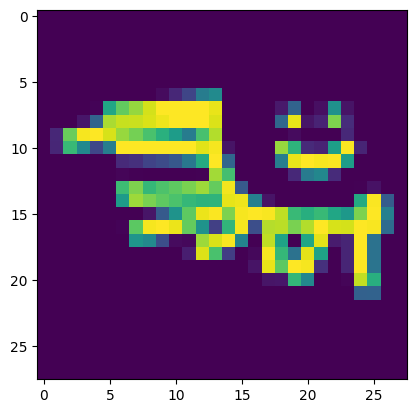

In [5]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
print(idx)
plt.imshow(x_train[idx].reshape(28,28))
print(x_train[idx].shape) 
print(class_names[int(y_train[idx].item())])

# Preprocess the Data 

In [6]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model 

In [7]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(8, activation='softmax')) 
# Train model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

# Training 

In [8]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Epoch 1/5
180/180 - 32s - loss: 0.6467 - top_k_categorical_accuracy: 0.9783 - val_loss: 0.3853 - val_top_k_categorical_accuracy: 0.9859 - 32s/epoch - 178ms/step
Epoch 2/5
180/180 - 37s - loss: 0.3150 - top_k_categorical_accuracy: 0.9890 - val_loss: 0.2918 - val_top_k_categorical_accuracy: 0.9908 - 37s/epoch - 206ms/step
Epoch 3/5
180/180 - 35s - loss: 0.2632 - top_k_categorical_accuracy: 0.9911 - val_loss: 0.2893 - val_top_k_categorical_accuracy: 0.9898 - 35s/epoch - 192ms/step
Epoch 4/5
180/180 - 32s - loss: 0.2366 - top_k_categorical_accuracy: 0.9926 - val_loss: 0.2584 - val_top_k_categorical_accuracy: 0.9891 - 32s/epoch - 180ms/step
Epoch 5/5
180/180 - 29s - loss: 0.2166 - top_k_categorical_accuracy: 0.9935 - val_loss: 0.2553 - val_top_k_categorical_accuracy: 0.9896 - 29s/epoch - 159ms/step


# Testing 

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 99.09%


# Inference 

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray
import PIL.ImageOps
import cv2
from random import randint
from pathlib import Path
import os
import time
import socket
import io
import os.path

1/1 [==============================] - 1s 598ms/step
moon
sent
1/1 [==============================] - 0s 304ms/step
moon
sent
1/1 [==============================] - 0s 164ms/step
square
sent
1/1 [==============================] - 0s 72ms/step
square
sent
1/1 [==============================] - 0s 133ms/step
square
sent
1/1 [==============================] - 0s 47ms/step
star
sent
1/1 [==============================] - 0s 92ms/step
moon
sent
1/1 [==============================] - 0s 67ms/step
square
sent
1/1 [==============================] - 0s 59ms/step
square
sent
1/1 [==============================] - 0s 81ms/step
square
sent
1/1 [==============================] - 0s 58ms/step
star
sent
1/1 [==============================] - 0s 77ms/step
baseball_bat
sent
1/1 [==============================] - 0s 73ms/step
moon
sent
1/1 [==============================] - 0s 29ms/step
apple
sent
1/1 [==============================] - 0s 89ms/step
apple
sent
1/1 [==============================] - 0s 60

KeyboardInterrupt: 

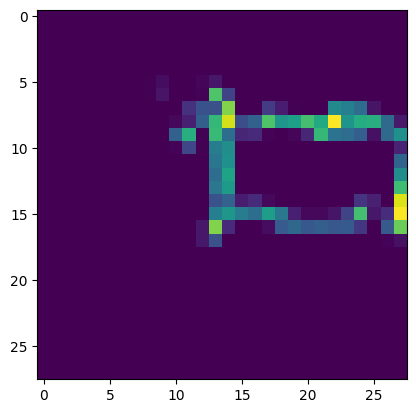

In [11]:
pathToImage = Path('./image1.png')

while True:
    time.sleep(5)
    if pathToImage.is_file() == True:
        originalImage = cv2.imread('image1.png')
        #scaled = cv2.resize(originalImage, (28, 28))
        grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)	
        (thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 10, 255, cv2.THRESH_BINARY)
        #(thresh, bblackAndWhiteImage) = cv2.threshold(blackAndWhiteImage, 254, 255, cv2.THRESH_BINARY)
        #cv2.imshow('Black white image', blackAndWhiteImage)
        #blackAndWhiteImage.save('grayscaled.png')
        #cv2.imwrite('test.png', bblackAndWhiteImage)
        imagem = cv2.bitwise_not(blackAndWhiteImage)
        cv2.imwrite('test.png', imagem)
        img_rg = Image.open('test.png')
        ggrayImage = img_rg.resize((28, 28))
        numpydata = asarray(ggrayImage)
        #cv2.imwrite('test1.png', numpydata)
        #print(numpydata.shape)
        nnn = numpydata.reshape(image_size, image_size, 1).astype('float32')
        #print(nnn.shape)
        #idx = randint(0, len(x_test))
        #img = x_test[idx]
        #print(x_test[idx].shape)
        plt.imshow(nnn.squeeze()) 
        pred = model.predict(np.expand_dims(nnn, axis=0))[0]
        ind = (-pred).argsort()[:5]
        latex = [class_names[ind[0]]]
        prediction = latex[0]

        print(prediction)

        # writing the file
        # f = open("prediction.txt", "w")
        # preddd = str(prediction)
        # f.write(preddd)
        # f.close()
        os.remove('image1.png')
        
        # start of client
        s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        host = "localhost"
        port = 3000
        s.connect(('localhost', port))

        # file = open("prediction.txt", "rb")
        # data = file.read()

        s.send(bytes(prediction, 'utf-8'))

        s.close()

        print("sent")


# Store the classes 

In [ ]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [ ]:
!pip install tensorflowjs 

    100% |████████████████████████████████| 327kB 6.4MB/s 
    100% |████████████████████████████████| 12.2MB 3.5MB/s 
  Found existing installation: numpy 1.14.3
    Uninstalling numpy-1.14.3:
      Successfully uninstalled numpy-1.14.3
  Found existing installation: Keras 2.1.6
    Uninstalling Keras-2.1.6:
      Successfully uninstalled Keras-2.1.6


# Save and Convert 

In [ ]:
model.save('keras.h5')

In [ ]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

mkdir: cannot create directory ‘model’: File exists
/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Zip and Download 

In [ ]:
!cp class_names.txt model/class_names.txt

In [ ]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/group5-shard1of1 (deflated 7%)
  adding: model/model.json (deflated 82%)
  adding: model/group2-shard1of1 (deflated 7%)
  adding: model/group3-shard1of1 (deflated 7%)
  adding: model/class_names.txt (deflated 41%)
  adding: model/group1-shard1of1 (stored 0%)
  adding: model/group4-shard1of1 (deflated 7%)


In [ ]:
from google.colab import files
files.download('model.zip')